# Data preparation

In [3]:
#suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import GridSearchCV

In [4]:
#SHEET_ID = '1pcmXXIryOc1hqpgFk3Tr3F3NaRjupklR9UtK7m0g-zA'
#SHEET_NAME = 'fraud-sms-dataset'
#url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'

df = pd.read_csv("sms-fraud-dataset.csv", header=None)
df.columns = ["label","text"]
df.head()

,label,text
0,ham,You listened to Signal by Eddy kenzo when you ...
1,spam,Call Germany for only 1 pence per minute! Call...
2,ham,Y'ello. MTN UGANDA LIMITED CISDATABUN has dedu...
3,ham,"You have withdrawn UGX 50,000 on 2023-03-02 12..."
4,ham,"Cash deposit of UGX 200,000 with Agent ID:1211..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1000 non-null   object
 1   text    1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


### Text Processing and Cleaning

In [6]:
df['label'] = df['label'].astype(str)
df['label'] = df['label'].str.strip()
df["label"].value_counts()

ham     803
spam    197
Name: label, dtype: int64

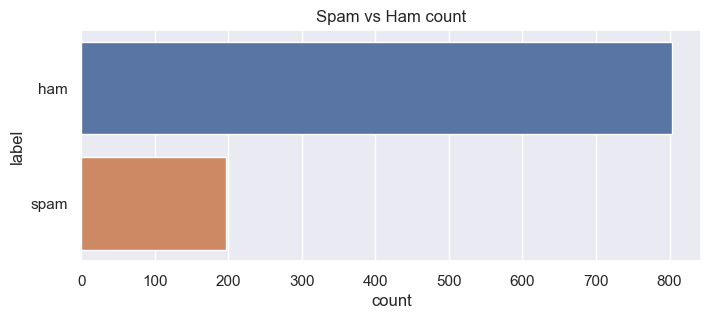

In [7]:
sns.set(rc={"figure.figsize":(8, 3)}) #width=8, height=3
sns.countplot(y='label', data=df).set(title='Spam vs Ham count');

#### Trim spaces and convert to lowercase

In [8]:
#Cast to string
df['text'] = df['text'].astype(str)
df['text'] = df['text'].str.strip().str.lower()

#### Expand contractions

In [9]:
import contractions
df['text'] = df['text'].apply(lambda x: contractions.fix(x))

#### Removing the punctuations

In [10]:
import string

# create function for punctuation removal:
def remove_punctuations(text):
    for char in string.punctuation:
        text = text.replace(char, '')
    return text

# apply the function:
df['text'] = df['text'].apply(remove_punctuations)

#### Removing the stopwords

In [11]:
# import list of stopwords:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# add more words to stopwords list:
guided_list = ['winning', 'prize', 'invest']
stopwords.extend(guided_list)

# update column without the stopwords:
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

#### Tokenize sentences

In [12]:
from nltk.tokenize import word_tokenize

#Create a tokenizer
def tokenize(column):
    tokens = word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 

#Tokenize the text data
df['tokenized'] = df.apply(lambda x: tokenize(x['text']), axis=1)
df[['tokenized']].head()

,tokenized
0,"[listened, signal, eddy, kenzo, called, set, h..."
1,"[call, germany, pence, per, minute, call, fixe..."
2,"[yello, mtn, uganda, limited, cisdatabun, dedu..."
3,"[withdrawn, ugx, fee, ugx, tax, ugx, new, bala..."
4,"[cash, deposit, ugx, agent, balance, ugx, tran..."


In [13]:
# Remove infrequent words and keep only words which are longer than 2 letters
df['text_string'] = df['tokenized'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

# Create a list of all words
all_words = ' '.join([word for word in df['text_string']])

# Tokenize all_words
tokenized_words = word_tokenize(all_words)


In [14]:
# Create a frequency distribution which records the number of times each word has occurred:
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist

FreqDist({'ugx': 1021, 'dial': 282, 'money': 278, 'balance': 270, 'mtn': 256, 'mobile': 256, 'new': 204, 'limited': 192, 'bundle': 180, 'uganda': 177, ...})

In [15]:
# Use fdist dictionary to drop words which occur less than a certain amount of times (usually 3 or 4).
df['text_string_fdist'] = df['tokenized'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))

#### Lemmatization

In [16]:
from nltk.stem import WordNetLemmatizer
wordnet = WordNetLemmatizer()

df['lemmatized'] = df['text_string_fdist'].apply(wordnet.lemmatize)
df.head()

,label,text,tokenized,text_string,text_string_fdist,lemmatized
0,ham,listened signal eddy kenzo called 0758341694 s...,"[listened, signal, eddy, kenzo, called, set, h...",listened signal eddy kenzo called set hello tu...,listened signal eddy kenzo called set hello tu...,listened signal eddy kenzo called set hello tu...
1,spam,call germany 1 pence per minute call fixed lin...,"[call, germany, pence, per, minute, call, fixe...",call germany pence per minute call fixed line ...,call germany pence per minute call fixed line ...,call germany pence per minute call fixed line ...
2,ham,yello mtn uganda limited cisdatabun deducted u...,"[yello, mtn, uganda, limited, cisdatabun, dedu...",yello mtn uganda limited cisdatabun deducted u...,yello mtn uganda limited cisdatabun deducted u...,yello mtn uganda limited cisdatabun deducted u...
3,ham,withdrawn ugx 50000 20230302 124607 fee ugx 15...,"[withdrawn, ugx, fee, ugx, tax, ugx, new, bala...",withdrawn ugx fee ugx tax ugx new balance ugx ...,withdrawn ugx fee ugx tax ugx new balance ugx ...,withdrawn ugx fee ugx tax ugx new balance ugx ...
4,ham,cash deposit ugx 200000 agent id1211542 balanc...,"[cash, deposit, ugx, agent, balance, ugx, tran...",cash deposit ugx agent balance ugx trans date,cash deposit ugx agent balance ugx trans date,cash deposit ugx agent balance ugx trans date


#### Word cloud

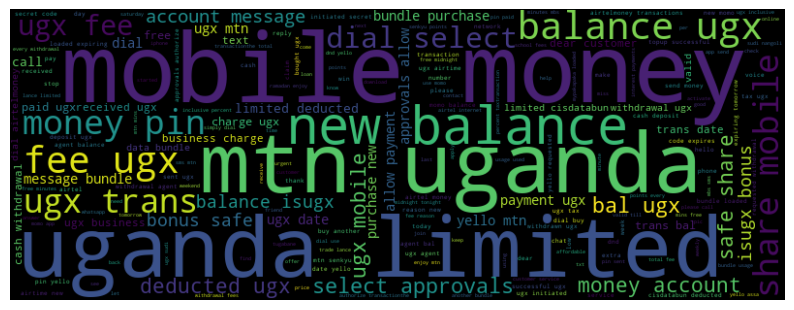

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words_lem = ' '.join([word for word in df['lemmatized']])

wordcloud = WordCloud(width=800, 
                     height=300, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

### Split data for classification

In [18]:
# Convert labeled data to encoded data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df['lemmatized_encd'] = le.fit_transform(df['lemmatized'])
#print('Text Encoded', df['lemmatized_encd'])

df['label_encd'] = le.fit_transform(df['label'])
#print('Label Encoded', df['label_encd'])

# Create feature set
#features = list(zip(text_encoded))

df.head()

,label,text,tokenized,text_string,text_string_fdist,lemmatized,lemmatized_encd,label_encd
0,ham,listened signal eddy kenzo called 0758341694 s...,"[listened, signal, eddy, kenzo, called, set, h...",listened signal eddy kenzo called set hello tu...,listened signal eddy kenzo called set hello tu...,listened signal eddy kenzo called set hello tu...,252,0
1,spam,call germany 1 pence per minute call fixed lin...,"[call, germany, pence, per, minute, call, fixe...",call germany pence per minute call fixed line ...,call germany pence per minute call fixed line ...,call germany pence per minute call fixed line ...,40,1
2,ham,yello mtn uganda limited cisdatabun deducted u...,"[yello, mtn, uganda, limited, cisdatabun, dedu...",yello mtn uganda limited cisdatabun deducted u...,yello mtn uganda limited cisdatabun deducted u...,yello mtn uganda limited cisdatabun deducted u...,484,0
3,ham,withdrawn ugx 50000 20230302 124607 fee ugx 15...,"[withdrawn, ugx, fee, ugx, tax, ugx, new, bala...",withdrawn ugx fee ugx tax ugx new balance ugx ...,withdrawn ugx fee ugx tax ugx new balance ugx ...,withdrawn ugx fee ugx tax ugx new balance ugx ...,452,0
4,ham,cash deposit ugx 200000 agent id1211542 balanc...,"[cash, deposit, ugx, agent, balance, ugx, tran...",cash deposit ugx agent balance ugx trans date,cash deposit ugx agent balance ugx trans date,cash deposit ugx agent balance ugx trans date,42,0


<Axes: title={'center': 'Verify that class distributuion in train is same as input data'}, xlabel='label_encd'>

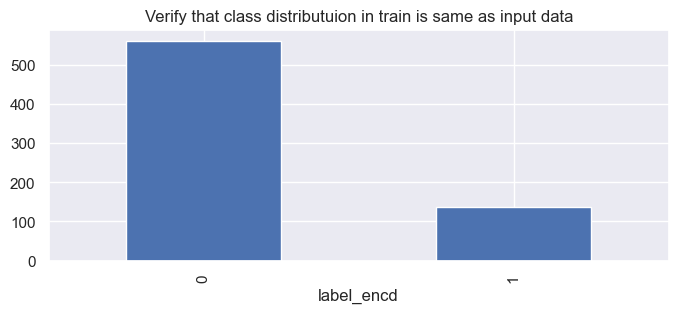

In [19]:
# Split the data into training and testing set
# Create a stratified train/test split. 
# Test set will be 30% of the data and Training set 70%.
# Class distribution will be equal for train test and original data

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, stratify=df.label_encd)

# Plot graph to verify that the class distribution in train is the same as in the original data.
train.pivot_table(index='label_encd', aggfunc='size').plot(kind='bar', title='Verify that class distributuion in train is same as input data')


<Axes: title={'center': 'Verify that class distributuion in test is same as input data'}, xlabel='label_encd'>

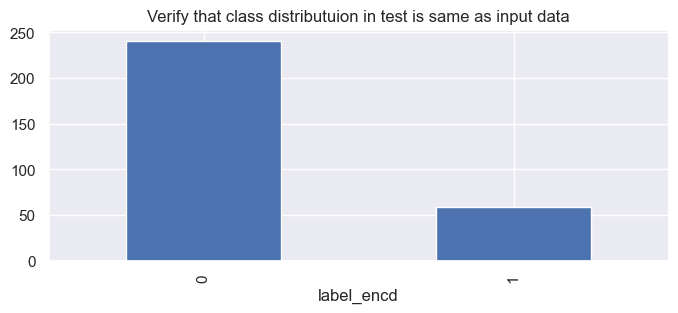

In [20]:
# Also check whether the stratification went well in the test data.
test.pivot_table(index='label_encd', aggfunc='size').plot(kind='bar', title='Verify that class distributuion in test is same as input data')

## Model Training

#### First building a Logistic Regression model on the original data

In [21]:
# Training the classifier
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

# Fit the logistic regression on the independent variables of the train data with label_encd as dependent variable
log_reg.fit(train[['lemmatized_encd']], train['label_encd'])

# Make a prediction using our model on the test set
log_reg_pred = log_reg.predict(test[['lemmatized_encd']])


In [22]:
# Evaluate the predictive performance by looking at the confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test['label_encd'], log_reg_pred).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  241 
False positives:  0 
False negatives:  59 
True Positives:  0


In [23]:
# View the classification report
from sklearn.metrics import classification_report
print(classification_report(test['label_encd'], log_reg_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       241
           1       0.00      0.00      0.00        59

    accuracy                           0.80       300
   macro avg       0.40      0.50      0.45       300
weighted avg       0.65      0.80      0.72       300



#### Use the SMOTE package to balance data

In [24]:
# transform the dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(train[['lemmatized_encd']], train['label_encd'])

<Axes: title={'center': 'Class distribution after appying SMOTE'}, xlabel='label_encd'>

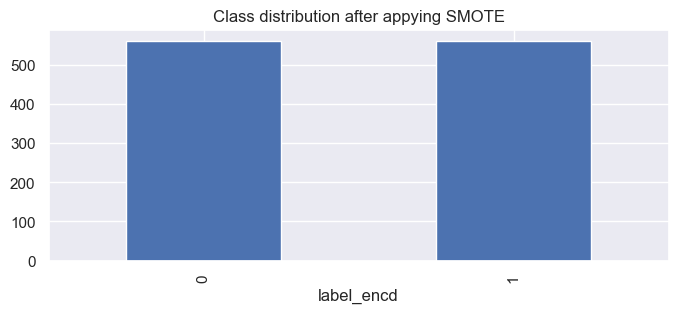

In [25]:
# verify the data is balanced
pd.Series(y_res).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE', xlabel='label_encd')


#### Logistic Regression classifier

In [38]:
#Tunning parameters
params = {
    'penalty' : ['l1','l2', 'none'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

lrc = LogisticRegression()
model = GridSearchCV(estimator = lrc, param_grid = params,  cv = 10)
model.fit(X_res, y_res)

print("Best: %f using %s" % (model.best_score_, model.best_params_))

Best: 0.539120 using {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}


In [39]:
#Training the model
lrc = LogisticRegression(solver='newton-cg', penalty='l2', C=0.001)
lrc.fit(X_res, y_res)

# evaluating the classifier
lrc_y_pred = lrc.predict(test[['lemmatized_encd']])

# looking at the confusion matrix
#tn, fp, fn, tp = confusion_matrix(test['label_encd'], lrc_y_pred).ravel()
#print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

# the classification report
print(classification_report(test['label_encd'], lrc_y_pred))

              precision    recall  f1-score   support

           0       0.83      0.50      0.63       241
           1       0.22      0.58      0.32        59

    accuracy                           0.52       300
   macro avg       0.52      0.54      0.47       300
weighted avg       0.71      0.52      0.57       300



#### Random forest classifier.

In [32]:
#Tunning parameters
from sklearn.ensemble import RandomForestClassifier

params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc = RandomForestClassifier(random_state=42)
model = GridSearchCV(estimator = rfc, param_grid = params,  cv = 5)
model.fit(X_res, y_res)

print("Best: %f using %s" % (model.best_score_, model.best_params_))

Best: 0.870079 using {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


In [33]:
# Training the classifier
rfc = RandomForestClassifier(random_state=42, criterion='gini', max_depth=8, max_features='auto', n_estimators= 500)
rfc.fit(X_res, y_res)

# evaluating the classifier
rfc_y_pred = rfc.predict(test[['lemmatized_encd']])

# the confusion matrix
#tn, fp, fn, tp = confusion_matrix(test['label_encd'], rfc_y_pred).ravel()
#print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

# the classification report
print(classification_report(test['label_encd'], rfc_y_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       241
           1       0.48      0.80      0.60        59

    accuracy                           0.79       300
   macro avg       0.71      0.79      0.73       300
weighted avg       0.85      0.79      0.81       300



#### KNN classifier

In [34]:
#Tunning parameters
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors' : list(range(1, 21)),
          'weights' : ['uniform','distance'],
          'metric' : ['minkowski','euclidean','manhattan']}

knn = KNeighborsClassifier()
model = GridSearchCV(estimator = knn, param_grid = params, verbose = 1, cv=3, n_jobs = -1)
model.fit(X_res, y_res)

print("Best: %f using %s" % (model.best_score_, model.best_params_))

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best: 0.867420 using {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}


In [35]:
# Training the classifier
knn = KNeighborsClassifier(n_neighbors=3, metric='minkowski', weights='uniform', algorithm='auto') 
knn.fit(X_res,y_res)

# evaluating the classifier
knn_y_pred = knn.predict(test[['lemmatized_encd']])

# the confusion matrix
#tn, fp, fn, tp = confusion_matrix(test['label_encd'], knn_y_pred).ravel()
#print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

# the classification report
print(classification_report(test['label_encd'], knn_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       241
           1       0.53      0.75      0.62        59

    accuracy                           0.82       300
   macro avg       0.73      0.79      0.75       300
weighted avg       0.85      0.82      0.83       300



#### SVM Model

In [36]:
#Tunning parameters
from sklearn.svm import SVC
params = {'C': [0.1, 1, 10, 100, 1000], 
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
          'kernel': ['rbf', 'poly', 'sigmoid']}

svc = SVC()
#model = GridSearchCV(estimator = svc, param_grid = params, refit = True, verbose = 1)
#model.fit(X_res, y_res)

#print("Best: %f using %s" % (model.best_score_, model.best_params_))
#print("Estimator: %s" % (grid.best_estimator_))

In [37]:
# Training the classifier
svc = SVC(probability=False, kernel='rbf', gamma=0.1, C=1)
svc.fit(X_res, y_res)

# evaluating the classifier
svc_y_pred = svc.predict(test[['lemmatized_encd']])

# the confusion matrix
#tn, fp, fn, tp = confusion_matrix(test['label_encd'], svc_y_pred).ravel()
#print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

# the classification report
print(classification_report(test['label_encd'], svc_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       241
           1       0.52      0.76      0.62        59

    accuracy                           0.82       300
   macro avg       0.73      0.80      0.75       300
weighted avg       0.85      0.82      0.83       300



#### XGBoost Classifier

In [38]:
#Tunning parameters
from xgboost import XGBClassifier

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

eval_set = [(X_res, y_res)]

estimator = XGBClassifier()

model = GridSearchCV(estimator=estimator, param_grid=params, cv=3, scoring="neg_log_loss")

model.fit(X_res, y_res, eval_set=eval_set, verbose=0)

print("Best: %f using %s" % (model.best_score_, model.best_params_))

Best: -0.351618 using {'colsample_bytree': 0.6, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8}


In [39]:
# Training the classifier
xgb = XGBClassifier(colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.8)
xgb.fit(X_res, y_res)

# evaluating the classifier
xgb_y_pred = xgb.predict(test[['lemmatized_encd']])

# the confusion matrix
#tn, fp, fn, tp = confusion_matrix(test['label_encd'], xgb_y_pred).ravel()
#print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

# the classification report
print(classification_report(test['label_encd'], xgb_y_pred))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       241
           1       0.56      0.83      0.67        59

    accuracy                           0.84       300
   macro avg       0.76      0.84      0.78       300
weighted avg       0.88      0.84      0.85       300



#### AdaBoost Classifier

In [40]:
# define the grid of values to search
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

params = {
    'n_estimators' : [10, 50, 100, 500], 
    'learning_rate'  : [0.0001, 0.001, 0.01, 0.1, 1.0]
}

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(AdaBoostClassifier(), param_grid=params, n_jobs=-1, cv=cv, scoring='accuracy')

# execute the grid search
grid_result = grid_search.fit(X_res, y_res)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.857946 using {'learning_rate': 1.0, 'n_estimators': 500}


In [41]:
# Training the classifier
abc = AdaBoostClassifier(n_estimators=500, learning_rate=1.0)
abc.fit(X_res, y_res)

# evaluating the classifier
abc_y_pred = abc.predict(test[['lemmatized_encd']])

# the confusion matrix
#tn, fp, fn, tp = confusion_matrix(test['label_encd'], abc_y_pred).ravel()
#print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

# the classification report
print(classification_report(test['label_encd'], abc_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       241
           1       0.43      0.78      0.56        59

    accuracy                           0.76       300
   macro avg       0.68      0.77      0.69       300
weighted avg       0.83      0.76      0.78       300



### AUC Curve

In [42]:
import sklearn.metrics as metrics

fpr, tpr, _ = metrics.roc_curve(test,  lrc_y_pred)
auc = round(metrics.roc_auc_score(test, lrc_y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

# fpr, tpr, _ = metrics.roc_curve(test,  rfc_y_pred)
# auc = round(metrics.roc_auc_score(test, rfc_y_pred), 4)
# plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

# fpr, tpr, _ = metrics.roc_curve(test,  knn_y_pred)
# auc = round(metrics.roc_auc_score(test, knn_y_pred), 4)
# plt.plot(fpr,tpr,label="K-Nearest Neighbor, AUC="+str(auc))

# fpr, tpr, _ = metrics.roc_curve(test,  svc_y_pred)
# auc = round(metrics.roc_auc_score(test, svc_y_pred), 4)
# plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))

# fpr, tpr, _ = metrics.roc_curve(test,  xgb_y_pred)
# auc = round(metrics.roc_auc_score(test, xgb_y_pred), 4)
# plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))

# fpr, tpr, _ = metrics.roc_curve(test,  abc_y_pred)
# auc = round(metrics.roc_auc_score(test, abc_y_pred), 4)
# plt.plot(fpr,tpr,label="AdaBoost, AUC="+str(auc))



#create ROC curve
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()

#add legend
plt.legend()

TypeError: '<' not supported between instances of 'int' and 'str'